In [7]:
from transformers import Blip2Processor
from src.models.blip2 import SurroundBlipImageProcessor
model_name = "Salesforce/blip2-opt-2.7b" 
# processor = SurroundBlipImageProcessor.from_pretrained(model_name)
processor = Blip2Processor.from_pretrained(model_name)
print(processor.tokenizer.pad_token_id)

1


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Optional, Union
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
import pandas as pd
import numpy as np
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로 설정
data_dir = Path("data\quic360")

class QuIC360Dataset(Dataset):
    def __init__(self, 
                 csv_file: str,
                 processor: Blip2Processor,
                 image_size: tuple = (224,224),
                 max_length: Optional[int] = None,
                 split: str = "train",
                 do_crop: bool = False,
                 fov: Optional[float] = None,
                 overlap_ratio: Optional[float] = None,
                 transform: bool = False):
        super().__init__()
        
        self.df = pd.read_csv(csv_file)
        self.processor = processor
        self.image_size = image_size
        self.max_length = max_length
        self.split = split
        self.do_crop = do_crop
        if self.do_crop:
            self.fov = fov
            self.overlap_ratio = overlap_ratio
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Dict[str, Union[torch.Tensor, str]]:
        # 이미지 경로와 질문, 정답을 가져옵니다.
        image_path = self.df.iloc[idx]["url"]
        question = self.df.iloc[idx]["query"]
        answer = self.df.iloc[idx]["annotation"]
        
        # 이미지를 로드합니다.
        image = Image.open((image_path)).convert("RGB")
        if image.height > image.width:
            image = image.rotate(90, expand=True)
        
        # 질문과 정답을 전처리합니다.
        inputs = self.processor(
            text=question,
            images=image,
            image_size=self.image_size,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        # 정답을 전처리합니다.
        answers = self.processor(
            text=answer,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        
        return {
            "inputs": inputs,
            "answers": answers,
        }
        
    


In [20]:
class QuIC360Dataset(Dataset):
    def __init__(self, 
                 csv_file: str,
                 processor: Blip2Processor,
                 image_size: tuple = (224,224),
                 max_length: Optional[int] = None,
                 split: str = "train",
                 do_crop: bool = False,
                 fov: Optional[float] = None,
                 overlap_ratio: Optional[float] = None,
                 transform: bool = False):
        super().__init__()
        
        self.df = pd.read_csv(csv_file)
        self.processor = processor
        self.image_size = image_size
        self.max_length = max_length
        self.split = split
        self.do_crop = do_crop
        if self.do_crop:
            self.fov = fov
            self.overlap_ratio = overlap_ratio
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Dict[str, Union[torch.Tensor, str]]:
        # 이미지 경로와 질문, 정답을 가져옵니다.
        image_path = self.df.iloc[idx]["url"]
        question = self.df.iloc[idx]["query"]
        answer = self.df.iloc[idx]["annotation"]
        
        # 이미지를 로드합니다.
        image = Image.open(image_path).convert("RGB")
        
        # 질문과 정답을 전처리합니다.
        inputs = self.processor(
            text=question,
            images=image,
            image_size=self.image_size,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        
        # 정답을 전처리합니다.
        answers = self.processor(
            text=answer,
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
        )
        
        # Hugging Face Trainer가 기대하는 평평한 구조로 반환
        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),  # (C, H, W)
            "input_ids": inputs["input_ids"].squeeze(0),        # (L1)
            "attention_mask": inputs["attention_mask"].squeeze(0),  # (L1)
            "labels": answers["input_ids"].squeeze(0),          # (L2)
            "image_path": image_path,
            "question": question,
            "answer": answer
        }

In [22]:
from typing import Any, Dict, List

def data_collator(features: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    """
    features: 리스트의 각 요소는 데이터셋에서 반환한 딕셔너리
    """
    # 배치 처리
    batch = {}
    
    # 숫자 데이터 처리
    if "pixel_values" in features[0]:
        # (B, 1, C, H, W) 형태로 만들기
        pixel_values = torch.stack([f["pixel_values"] for f in features])
        batch["pixel_values"] = pixel_values.unsqueeze(1)  # (B, C, H, W) -> (B, 1, C, H, W)
    
    if "input_ids" in features[0]:
        batch["input_ids"] = torch.stack([f["input_ids"] for f in features])
    
    if "attention_mask" in features[0]:
        batch["attention_mask"] = torch.stack([f["attention_mask"] for f in features])
    
    if "labels" in features[0]:
        labels = torch.stack([f["labels"] for f in features])
        # Padding 토큰을 -100으로 마스킹
        labels = labels.masked_fill(labels == 1, -100)
        batch["labels"] = labels
    
    # 문자열 데이터 처리 (평가용)
    if "image_path" in features[0]:
        batch["image_paths"] = [f["image_path"] for f in features]
    
    if "question" in features[0]:
        batch["questions"] = [f["question"] for f in features]
    
    if "answer" in features[0]:
        batch["answers"] = [f["answer"] for f in features]
    
    return batch
# DataLoader 생성
train_dataset = QuIC360Dataset(data_dir/"downtest.csv", processor, max_length=30, split="valid")
loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=data_collator)

# 테스트
batch = next(iter(loader))
print(batch["pixel_values"].shape)   # (B, 1, C, H, W)
print(batch["input_ids"].shape)      # (B, L1)
print(batch["labels"].shape)         # (B, L2)

torch.Size([4, 1, 3, 224, 224])
torch.Size([4, 62])
torch.Size([4, 62])


dict_keys(['input_ids', 'attention_mask', 'pixel_values'])
torch.Size([4, 1, 3, 224, 224])
torch.Size([4, 1, 62])
torch.Size([4, 1, 62])
dict_keys(['input_ids', 'attention_mask'])
torch.Size([4, 1, 62])
1


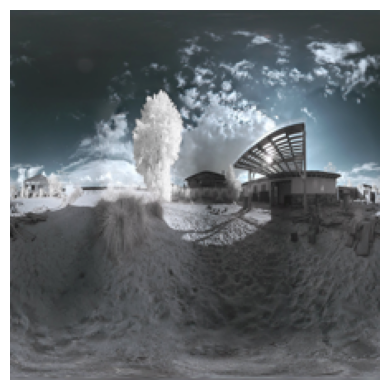

In [ ]:
import matplotlib.pyplot as plt
OPENAI_CLIP_MEAN = [0.48145466, 0.4578275, 0.40821073]
OPENAI_CLIP_STD = [0.26862954, 0.26130258, 0.27577711]

# No Crop
train_dataset = QuIC360Dataset(data_dir/"downtest.csv", processor, max_length=30, split="valid")
loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
    
batch = next(iter(loader))



inputs = batch["inputs"]
print(inputs.keys())
print(inputs["pixel_values"].shape)
print(inputs["input_ids"].shape)
print(inputs["attention_mask"].shape)

answers = batch["answers"]
print(answers.keys())
print(answers["input_ids"].shape)

num_patches = inputs["pixel_values"].shape[1]
print(num_patches)
plt.figure(figsize=(4 * num_patches, 4))
image = inputs["pixel_values"][0][0].permute(1, 2, 0).cpu().numpy()
image = (image * OPENAI_CLIP_STD + OPENAI_CLIP_MEAN) * 255.0
image = np.clip(image, 0, 255).astype(np.uint8)

plt.imshow(image)
plt.axis("off")
plt.tight_layout()
plt.show()

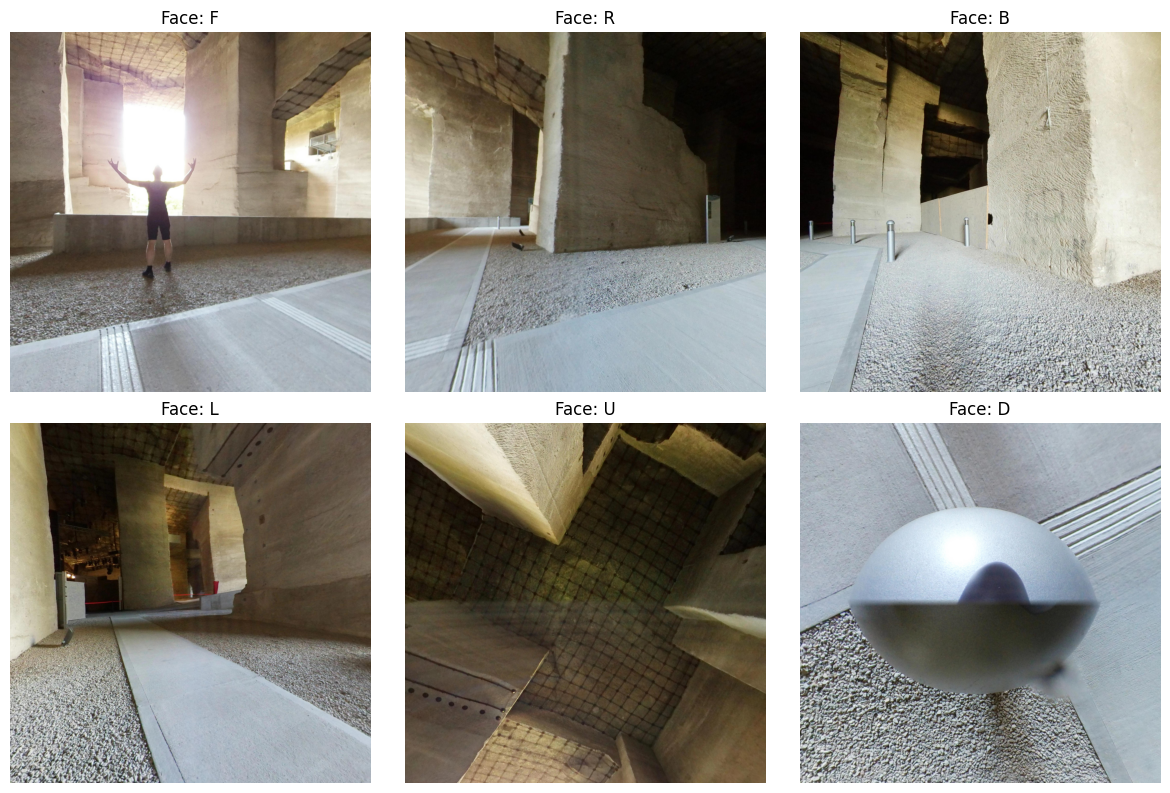

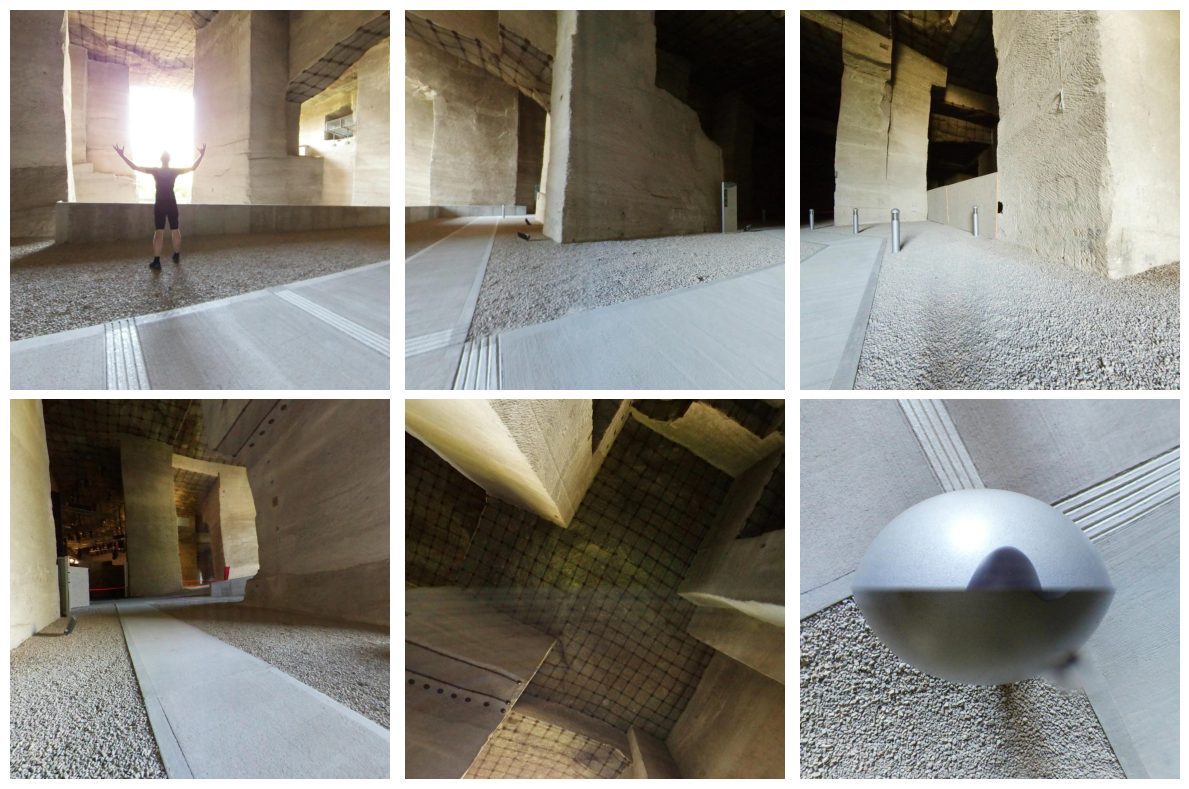

In [4]:
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

import numpy as np
from py360convert import  e2c, e2p

def split_360_to_cubemap_views(equirect_img, fov=90, overlap_ratio=0.5):
    """
    360도 이미지를 큐브맵으로 변환한 후 원하는 FOV와 overlap으로 자른 이미지들을 반환
    
    Args:
        equirect_img: numpy array, 360도 이미지 (H:W = 1:2)
        fov: 시야각 (기본값 90도)
        overlap_ratio: 겹침 비율 (기본값 0.5)
    
    Returns:
        views: 잘라진 이미지들의 리스트
    """
    return 0
    # 입력 이미지 크기 확인
    h, w = equirect_img.shape[:2]
    assert w == 2 * h, "Input image must have 1:2 aspect ratio (360° image)"

url = "https://live.staticflickr.com/65535/50333141271_afd4f08f1c_o.jpg"
response = requests.get(url)
equirect_img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
overlap_ratio =0.5    
fov = 90
h, w = equirect_img.shape[:2]
# 큐브맵 한 면의 크기 결정 (정사각형에 가깝게)
face_size = h // 2

# Equirectangular -> CubeMap 변환
cubemap = e2c(equirect_img, face_w=face_size, mode='bilinear', cube_format='dict')

# FOV 90도에 맞는 출력 이미지 크기 계산
output_size = int(face_size * np.tan(np.radians(fov/2)) * 2)

# overlap 계산
overlap_pixels = int(output_size * overlap_ratio)
step_size = output_size - overlap_pixels

views = [v for v in cubemap.values()]  # 리스트 컴프리헨션 사용

# rlfb 합치기

    

# Face 시각화
plt.figure(figsize=(12, 8))
for i, face_key in enumerate(cubemap):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(cubemap[face_key])
    ax.set_title(f"Face: {face_key}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# 전체 시각화
plt.figure(figsize=(12, 8))
for i, view in enumerate(views):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(view)
    ax.axis("off")
plt.tight_layout()
plt.show()